In [18]:
import xarray as xr
import dask
import numpy as np
import pandas as pd

In [19]:
DS = xr.open_mfdataset('/home/z5113258/Documents/data/ARGO/RG_ArgoClim_Temperature_2019.nc', decode_times=False, parallel=True)

In [20]:
DS

<xarray.Dataset>
Dimensions:                   (LATITUDE: 145, LONGITUDE: 360, PRESSURE: 58, TIME: 180)
Coordinates:
  * LONGITUDE                 (LONGITUDE) float32 20.5 21.5 22.5 ... 378.5 379.5
  * LATITUDE                  (LATITUDE) float32 -64.5 -63.5 -62.5 ... 78.5 79.5
  * PRESSURE                  (PRESSURE) float32 2.5 10.0 ... 1.9e+03 1.975e+03
  * TIME                      (TIME) float32 0.5 1.5 2.5 ... 177.5 178.5 179.5
Data variables:
    ARGO_TEMPERATURE_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(58, 145, 360), meta=np.ndarray>
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(180, 58, 145, 360), meta=np.ndarray>
    BATHYMETRY_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(58, 145, 360), meta=np.ndarray>
    MAPPING_MASK              (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(58, 145, 360), meta=np.ndarray>

In [21]:
DS['TEMP'] = DS.ARGO_TEMPERATURE_ANOMALY + DS.ARGO_TEMPERATURE_MEAN

In [22]:
test = pd.date_range("2004-01-01",freq="M", periods=180)


In [23]:
DS['TIME'] = test

In [24]:
T = DS.TEMP

In [25]:
T = T.rename({'LONGITUDE': 'lon','LATITUDE': 'lat', 'TIME':'time', 'PRESSURE':'pres'})

In [27]:
T.to_netcdf("/home/z5113258/Documents/data/CMIP6_HB/ARGO/ARGO_t.nc")

In [9]:
T = T.sel(pres=slice(0,51)).sel(lat=slice(-40,30),lon=slice(30,125))

In [10]:
#Calculate temperatur etendency of T_C
dTdt = T.differentiate(coord = 'time', edge_order=1,  datetime_unit= 's')

In [11]:
def get_weights(INP):
    weights = INP.pres
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'pres': INP.pres},
                 dims=['pres'])
    return thickness_DA

def weighted_avg(inp):
    weights = get_weights(inp)
    avg=inp.weighted(weights).mean('pres')
    return avg

In [12]:
dTdt

<xarray.DataArray 'TEMP' (time: 180, pres: 6, lat: 70, lon: 95)>
dask.array<_trim, shape=(180, 6, 70, 95), dtype=float32, chunksize=(180, 6, 70, 95), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float32 -39.5 -38.5 -37.5 -36.5 -35.5 ... 26.5 27.5 28.5 29.5
  * pres     (pres) float32 2.5 10.0 20.0 30.0 40.0 50.0
  * time     (time) datetime64[ns] 2004-01-31 2004-02-29 ... 2018-12-31

In [13]:
dTdt_w = weighted_avg(dTdt)

In [14]:
dTdt_w

<xarray.DataArray 'TEMP' (time: 180, lat: 70, lon: 95)>
dask.array<truediv, shape=(180, 70, 95), dtype=float64, chunksize=(180, 70, 95), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float32 -39.5 -38.5 -37.5 -36.5 -35.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 2004-01-31 2004-02-29 ... 2018-12-31

In [15]:
dTdt_w = dTdt_w.groupby('time.month').mean('time')

In [16]:
dTdt_w

<xarray.DataArray 'TEMP' (month: 12, lat: 70, lon: 95)>
dask.array<stack, shape=(12, 70, 95), dtype=float64, chunksize=(1, 70, 95), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float32 -39.5 -38.5 -37.5 -36.5 -35.5 ... 26.5 27.5 28.5 29.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


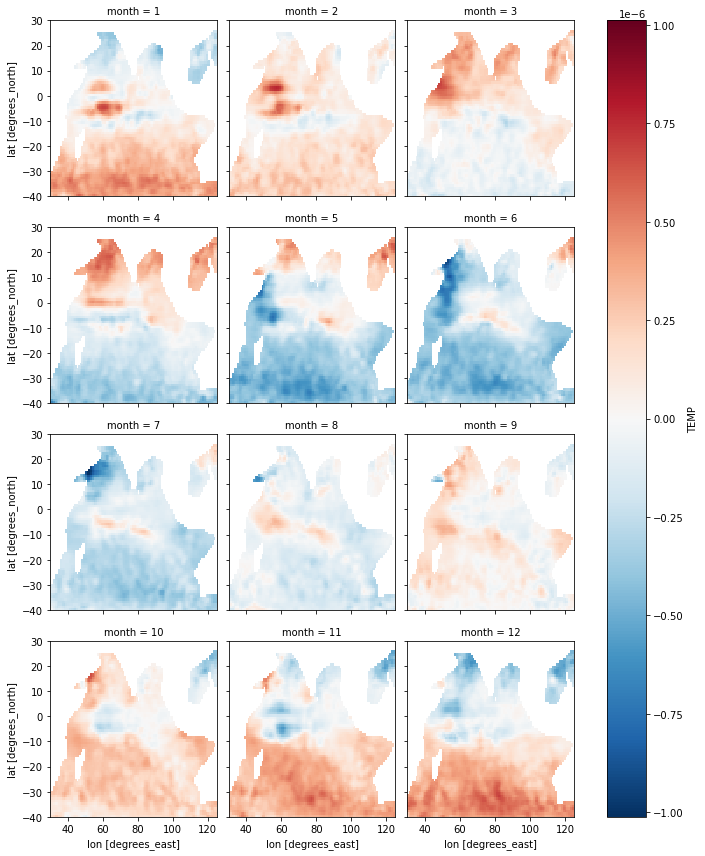

In [17]:
dTdt_w.plot(col='month', col_wrap = 3)

In [193]:
dTdt_w.to_netcdf('/home/z5113258/Documents/data/CMIP6_HB/ARGO/ARGO_temp_tendency.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [184]:
T_w = weighted_avg(T)

In [185]:
T_w = T_w.groupby('time.month').mean('time')

In [194]:
T_w.to_netcdf("/home/z5113258/Documents/data/CMIP6_HB/ARGO/ARGO_t50.nc")

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
#lets also get ARGO at surface 

In [187]:
T_surf = T.sel(pres=slice(0,5))

In [191]:
T_surf = T_surf[:,0,:,:].drop_vars('pres')

In [192]:
T_surf = T_surf.groupby('time.month').mean('time')

In [195]:
T_surf.to_netcdf("/home/z5113258/Documents/data/CMIP6_HB/ARGO/ARGO_tos.nc")

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
#load in z20 for argo

In [28]:
z20 = xr.open_mfdataset('/home/z5113258/Documents/data/ARGO/z20_argo.nc', parallel = True)

In [29]:
z20 = z20.groupby('time.month').mean('time')

In [30]:
z20 = z20.sel(lat=slice(-40,30),lon=slice(30,125))

In [31]:
z20.to_netcdf("/home/z5113258/Documents/data/CMIP6_HB/ARGO/ARGO_z20.nc")

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [53]:
#now lets get surface temperature data for re-analysis data

In [157]:
#load in GODAS
GT = xr.open_mfdataset('/home/z5113258/Documents/GODAS/remapbil_1/pottmp/pottmp.*.nc', parallel = True)

In [158]:
GT = GT.pottmp.sel(lat=slice(-40,30),lon=slice(30,125)).sel(level=slice(5))

In [159]:
GT = GT.groupby('time.month').mean('time')

In [160]:
GT = GT[:,0,:].drop("level")

In [161]:
GT = GT-273.15

In [163]:
#save GODAS surf Temp
GT.to_netcdf('/home/z5113258/Documents/data/CMIP6_HB/GODAS/GODAS_tos.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [146]:
#load in SODA

In [147]:
ST = xr.open_mfdataset('/home/z5113258/Documents/SODA3.4.2/temp_7/soda3.4.2_mn_ocean_reg_*.nc', parallel = True)

In [148]:
ST = ST.temp.sel(lat=slice(-40,30),lon=slice(30,125)).sel(st_ocean=slice(0,6))

In [149]:
ST = ST.groupby('time.month').mean('time')

In [150]:
ST = ST[:,0,:].drop("st_ocean")

In [151]:
ST.to_netcdf('/home/z5113258/Documents/data/CMIP6_HB/SODA3.4.2/SODA3.4.2_tos.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [152]:
#load in ORAS5

In [153]:
OT = xr.open_mfdataset('/home/z5113258/Documents/ORAS5/sosstsst_surf/sosstsst_ORAS5_1m_*.nc', parallel = True)

In [154]:
OT = OT.sosstsst.sel(lat=slice(-40,30),lon=slice(30,125))

In [155]:
OT = OT.groupby('time_counter.month').mean('time_counter')

In [156]:
OT.to_netcdf('/home/z5113258/Documents/data/CMIP6_HB/ORAS5/ORAS5_tos.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', length=180, freq='M')